# Overview of solar position data and its relationship to weather and training data

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns

import ipywidgets as widgets

In [2]:
__context__ = 'local'

import sys

if __context__ == 'local':
    trainDataLocation = '../data/train/'
    libraryLocation = '../'

elif __context__ == 'kaggle':
    trainDataLocation = '/kaggle/input/predict-energy-behavior-of-prosumers/'
    libraryLocation = '/kaggle/input/'

sys.path.append(libraryLocation)

from enefittools.data import format_dfs

train = pd.read_csv(trainDataLocation+'train.csv')
client = pd.read_csv(trainDataLocation+'client.csv')

#weather_forecast = pd.read_csv(trainDataLocation+'forecast_weather.csv')
weather_historical = pd.read_csv(trainDataLocation+'historical_weather.csv')

solar = pd.read_csv(libraryLocation + '/enefittools/data/datasets/solar_data.csv')

train, client, weather_historical, solar = \
                format_dfs(target=train, client=client, weather_historical=weather_historical,
                           solar=solar)


## First, check if the solar data aligns with the day / night cycles that we observe in the data.

The weather data has solar radiation data.

For the solar position data,
latitude=58.60, longitude=25.01

Lets compare to the weather data at (58.5, 25.2)



In [3]:
talininData = weather_historical.filter( pl.col('latitude') == 58.5, pl.col('longitude') == 25.2
                               ).join( solar, on='datetime'
                               ).select('datetime', 'direct_solar_radiation', 'solar_elevation')

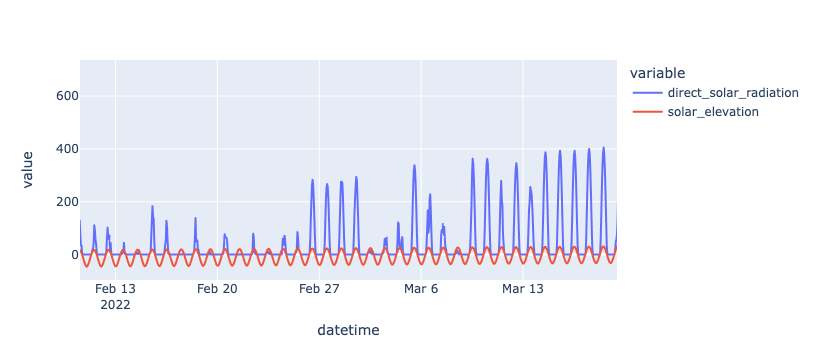

In [16]:
import plotly.express as px

px.line(talininData, x='datetime', y=['direct_solar_radiation', 'solar_elevation'])

Ok, these actually seem to line up very well. As a qualitative check, we can filter by times when the the solar elevation is negative

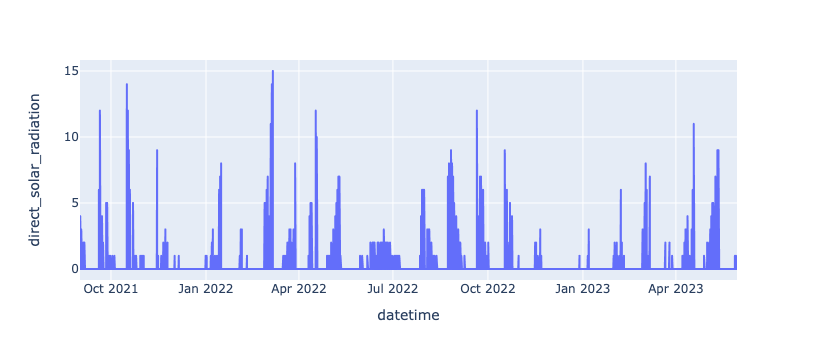

In [17]:
px.line( talininData.filter( pl.col('solar_elevation') <= 0.), x='datetime', y='direct_solar_radiation') 

Ok, it's not perfect, but the deviations are relatively small

#### Comparing solar and weather data for all locations

In [63]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

fullData = weather_historical.join( solar, on='datetime'
                            ).select(
                                'datetime', 'direct_solar_radiation', 'solar_elevation',
                                'latitude', 'longitude'
                            )
locations = list( map( lambda row: str(row[0][0]) + ', ' + str(row[0][1]),
    fullData.select('latitude', 'longitude'
       ).unique(
       ).select( pl.concat_list(pl.col('latitude'), pl.col('longitude') )
       ).rows()
))

app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(locations, id='dropdown-selection'),
    dcc.Slider(0, len(locations)+1, 1, value=0, marks=None, id='location_slider'),
    dcc.Graph(id='graph-content')
])

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value'),
    Input('location_slider', 'value')
)
def update_graph(value, slider_ind):
    latitude=58.5
    longitude=25.2
    if value is not None:
        latitude, longitude = map(float, value.split(','))
    if slider_ind != 0:
        latitude, longitude = map(float, locations[slider_ind-1].split(','))
        

    to_plot= fullData.filter(pl.col('latitude') == latitude,
                             pl.col('longitude') == longitude,
                             pl.col('solar_elevation') <=0
                    ).to_pandas()
    
    return px.line(to_plot, x='datetime', y='direct_solar_radiation', title=f'Location: {latitude}, {longitude}')

if __name__ == '__main__':
    app.run(debug=True)

Looking through these values, a couple of things stand out
1. This dataset is good enough for most locations, except two that have large night-time illumination: (57.6, 23.2), and (57.6, 24.2)
   - are both datapoints in the Gulf of Riga
3. Larger longitudes have an error peak in July, while smaller latitudes have more concentrated errors in May and April


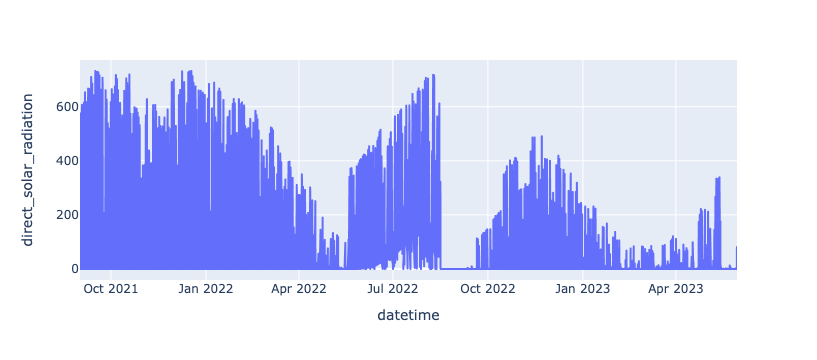

In [19]:
px.line( 
    fullData.filter(pl.col('latitude') == 57.6, pl.col('longitude') == 23.2,
                    pl.col('solar_elevation') <0
                   ).to_pandas(),
    x='datetime', y='direct_solar_radiation'
)

### Does the solar data at the specific locations match the weather data better?

In [8]:
from astral.location import LocationInfo, Location

strange_location = Location(LocationInfo(
                                    name='Estonia',
                                    region='Estonia',
                                    latitude=57.6, longitude=23.2,
                                    timezone="Europe/Tallinn"
                                ))

all_times = pd.date_range('2021-09-01 00:00:00', '2024-12-31 23:00:00', freq='H').to_series()
all_times.index = all_times.index.rename('datetime')

In [9]:
solar_on_location = pl.from_pandas(all_times.apply(strange_location.solar_elevation).rename('solar_elevation').reset_index(),
                                   schema_overrides={'datetime': pl.Datetime('ms')})

multiple_locations_solar_data = fullData.filter(pl.col('latitude') == 57.6, pl.col('longitude') == 23.2,
       ).join(solar_on_location, on='datetime', suffix='_new'
       ) 

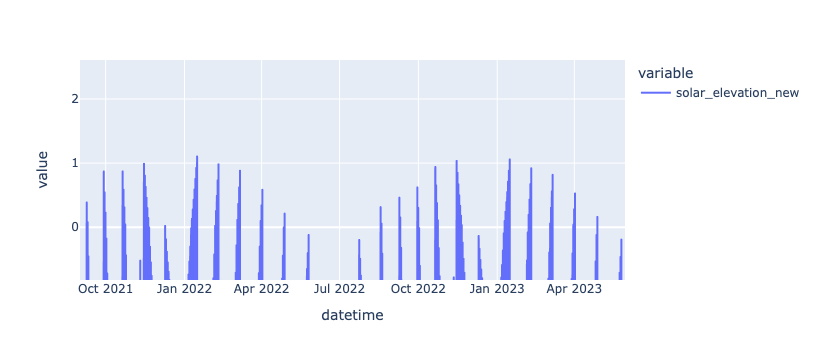

In [20]:
px.line( 
    multiple_locations_solar_data.filter(pl.col('solar_elevation')<0),
    x='datetime', y=['solar_elevation_new']
)

This pattern looks quite similar to the 'normal' timecourse of errors that we saw above, which probably results from the slight differences in location. It does not explain the massive deviations that we see.

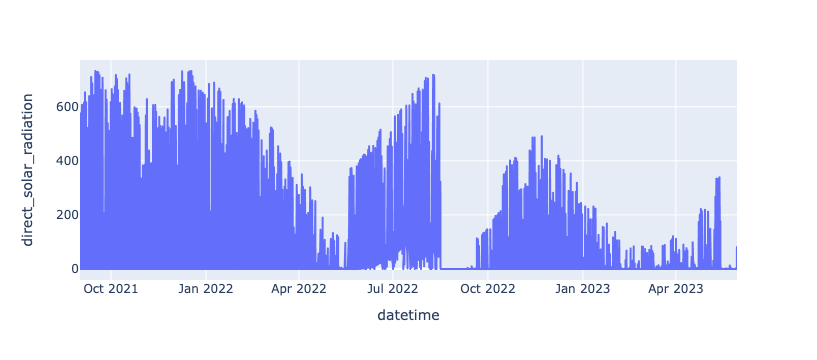

In [11]:
px.line( 
    multiple_locations_solar_data.filter( pl.col('solar_elevation_new') < 0.),
    x='datetime', y='direct_solar_radiation'
)

If anything, it seems like the timezone is off for this weather data.

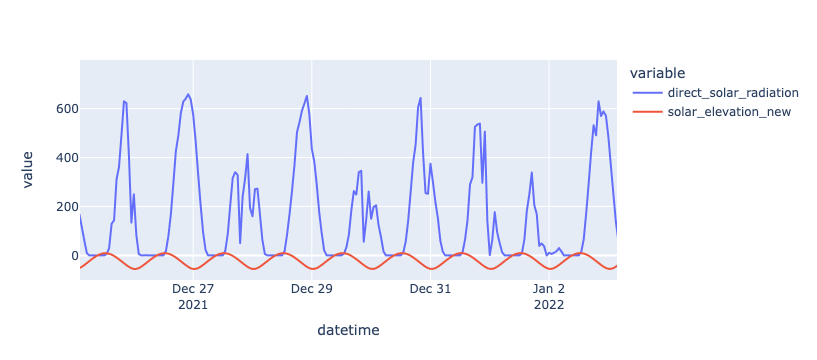

In [18]:
px.line( 
    multiple_locations_solar_data,
    x='datetime', y=['direct_solar_radiation', 'solar_elevation_new']
)

This is off by more than just a shift of hours. The day and night lengths seem totally wrong for the season!

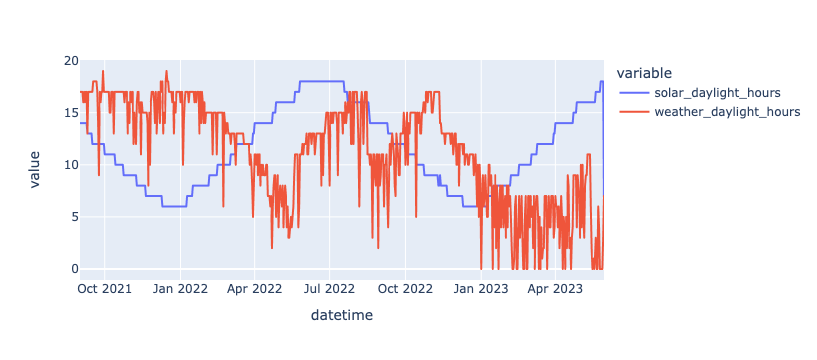

In [13]:
px.line(
    multiple_locations_solar_data.group_by(pl.col('datetime').dt.date()
                                ).agg((pl.col('solar_elevation_new') > 0).sum().alias('solar_daylight_hours'),
                                      (pl.col('direct_solar_radiation') > 0).sum().alias('weather_daylight_hours')
                                ).sort('datetime'),
    x='datetime', y=['solar_daylight_hours', 'weather_daylight_hours']
)

Indeed this datapoint seems quite off. The control looks like:

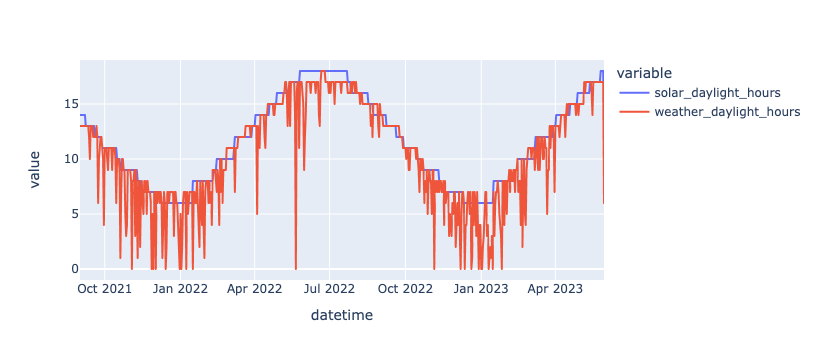

In [14]:
px.line(
    fullData.filter(pl.col('latitude')==57.6, pl.col('longitude')==21.7
           ).group_by(pl.col('datetime').dt.date()
           ).agg((pl.col('solar_elevation') > 0).sum().alias('solar_daylight_hours'),
                 (pl.col('direct_solar_radiation') > 0).sum().alias('weather_daylight_hours')
           ).sort('datetime'),
        x='datetime', y=['solar_daylight_hours', 'weather_daylight_hours']
)

The other 'different' spot looks like:

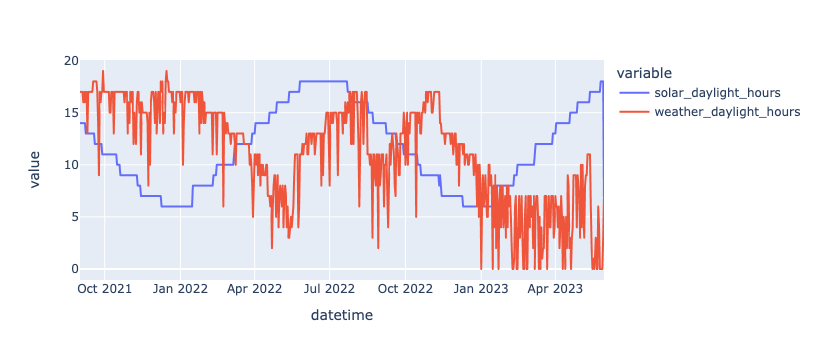

In [21]:
px.line(
    fullData.filter(pl.col('latitude')==57.6, pl.col('longitude')==23.2
           ).group_by(pl.col('datetime').dt.date()
           ).agg((pl.col('solar_elevation') > 0).sum().alias('solar_daylight_hours'),
                 (pl.col('direct_solar_radiation') > 0).sum().alias('weather_daylight_hours')
           ).sort('datetime'),
        x='datetime', y=['solar_daylight_hours', 'weather_daylight_hours']
)

#### Answer: No.

This data is _very_ strange. It really seems like it's not correctly recorded or not correctly associated to the time / date in question.
It think that the best thing to initially is to simply filter out the weather data at these particular locations

### How does solar elevation data compare to weather data for the exact locations in question?

In [40]:
full_solar = pd.read_csv(libraryLocation + '/enefittools/data/datasets/solar_data_full.csv')

In [42]:
full_solar = format_dfs(solar=full_solar)[0]

#### Comparing weather data to solar data from the same location

In [59]:
alike_solar_weather = weather_historical.join(full_solar, on=['datetime', 'latitude', 'longitude'], how='left')

In [64]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd

locations = list( map( lambda row: str(row[0][0]) + ', ' + str(row[0][1]),
    alike_solar_weather.select('latitude', 'longitude'
       ).unique(
       ).select( pl.concat_list(pl.col('latitude'), pl.col('longitude') )
       ).rows()
))

app = Dash(__name__)

app.layout = html.Div([
    dcc.Dropdown(locations, id='dropdown-selection'),
    dcc.Slider(0, len(locations)+1, 1, value=0, marks=None, id='location_slider'),
    dcc.Graph(id='graph-content')
])

@callback(
    Output('graph-content', 'figure'),
    Input('dropdown-selection', 'value'),
    Input('location_slider', 'value')
)
def update_graph(value, slider_ind):
    latitude=58.5
    longitude=25.2
    if value is not None:
        latitude, longitude = map(float, value.split(','))
    if slider_ind != 0:
        latitude, longitude = map(float, locations[slider_ind-1].split(','))
        

    to_plot= alike_solar_weather.filter(pl.col('latitude') == latitude,
                             pl.col('longitude') == longitude,
                             pl.col('solar_elevation') <=0
                    ).to_pandas()
    
    return px.line(to_plot, x='datetime', y='direct_solar_radiation', title=f'Location: {latitude}, {longitude}')

if __name__ == '__main__':
    app.run(debug=True)

It may be slightly better, but it's difficult to tell.

In [73]:
alike_solar_weather.filter(pl.col('solar_elevation') < 0.,
                           ((pl.col('latitude') != 57.6) | (pl.col('longitude') != 23.2)),
                           ((pl.col('latitude') != 57.6) | (pl.col('longitude') != 24.2))
                          ).select('direct_solar_radiation').sum()

shape: (1, 1)
┌────────────────────────┐
│ direct_solar_radiation │
│ ---                    │
│ f64                    │
╞════════════════════════╡
│ 80838.0                │
└────────────────────────┘

In [75]:
fullData.filter(pl.col('solar_elevation') < 0.,
                    ((pl.col('latitude') != 57.6) | (pl.col('longitude') != 23.2)),
                    ((pl.col('latitude') != 57.6) | (pl.col('longitude') != 24.2))
                ).select('direct_solar_radiation').sum()

shape: (1, 1)
┌────────────────────────┐
│ direct_solar_radiation │
│ ---                    │
│ f64                    │
╞════════════════════════╡
│ 86045.0                │
└────────────────────────┘

It is indeed slightly better. I'm not sure that thats worth much, but the much of the improvement appears to be in the most extreme data points, so it may be worth something.